In [1]:
from cobra.sampling import ACHRSampler
from cobra.sampling import OptGPSampler
import cobra
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
import statsmodels
from scipy.stats import sem, t
from scipy import mean
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns
from scipy.stats import hypergeom


%matplotlib inline

In [2]:
subs=pd.read_csv('ReactionSetNHBE.csv')

In [3]:
dataset=pd.DataFrame()
for path in subs['Var2'].unique():
    reaction_set=subs.loc[subs['Var2']==path,'Var1']
    rxn=reaction_set.reset_index(drop=True)
    df_temp=pd.DataFrame({path:rxn})
    dataset=pd.concat([dataset,df_temp],axis=1)

In [4]:
# dataset.to_csv('ReactionSetStructuredNHBE.csv')

In [7]:
rxnlist=pd.read_csv('ImpactedReactionsNHBE.csv')

In [8]:
listSize=len(rxnlist)
listrxnSize=[]
setSize=[]
rxnSize=7196

for col in dataset.columns:
    df=pd.DataFrame({'Reaction':dataset[col]})
    out=df.merge(rxnlist)
    listrxnSize.append(len(out))
    setSize.append(len(dataset[col].dropna()))

hyperdata=pd.DataFrame({'Pathways':dataset.columns,'ListReactions':listrxnSize,'SetSize':setSize})
    

In [9]:
hits=hyperdata['ListReactions']
pool=hyperdata['SetSize']
allrxns=hyperdata['SetSize'].sum()
targetrxns=hyperdata['ListReactions'].sum()

In [10]:
allrxns

7196

In [11]:
pvalList=[]
for h,p in zip(hits,pool):
    rv=hypergeom(allrxns-p,p,targetrxns)
    pval=rv.pmf(h)
    pvalList.append(pval)

hyperdata['P-value']=pvalList
reject,padj,_,_=statsmodels.stats.multitest.multipletests(hyperdata['P-value'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
hyperdata['P-valueadj']=padj
hyperdata['Reject']=reject

In [12]:
targetrxns

839

In [13]:
    rv=hypergeom(7196-370,370,765)
    pval=rv.pmf(41)

In [14]:
pval

0.06756808348946816

In [15]:
hyperdata.sort_values(by='ListReactions',ascending=False)

,Pathways,ListReactions,SetSize,P-value,P-valueadj,Reject
0,Transport reactions,273,2028,2.115104e-06,2.595809e-05,True
4,Fatty acid oxidation,71,370,2.721740e-05,2.624535e-04,True
20,Exchange/demand reactions,41,790,4.775790e-15,2.149106e-13,True
93,Nucleotide metabolism,37,109,6.922809e-10,1.557632e-08,True
30,Carnitine shuttle (mitochondrial),33,109,1.236542e-07,1.669331e-06,True
79,Beta oxidation of unsaturated fatty acids (n-9...,24,38,5.955732e-14,2.010060e-12,True
31,Fatty acid activation (cytosolic),23,59,5.599091e-08,8.398637e-07,True
48,Cholesterol biosynthesis 1 (Bloch pathway),19,27,1.386397e-12,3.743272e-11,True
77,Beta oxidation of di-unsaturated fatty acids (...,18,19,2.377427e-16,3.209527e-14,True
29,Carnitine shuttle (cytosolic),18,55,2.371790e-05,2.463012e-04,True


In [16]:
hyperdata_sig=hyperdata[(hyperdata['Reject']) & (hyperdata['ListReactions']!=0)]
hyperdata_sorted=hyperdata_sig.sort_values(by='P-valueadj',ascending=False)

In [17]:
hyperdata_sorted=hyperdata_sorted.drop([0,20],axis=0) #Remove transport reactions and exchange reactions

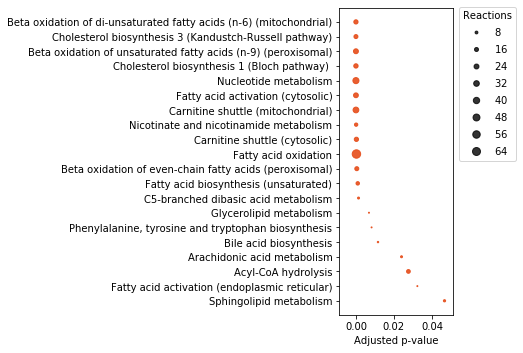

In [19]:
plt.figure(figsize=(12,5))

sc=plt.scatter(hyperdata_sorted['P-valueadj'],np.arange(0,len(hyperdata_sorted['Pathways'])),s=hyperdata_sorted['ListReactions'],color=(0.9,0.3,0.1,0.9))
plt.xlabel('Adjusted p-value')
plt.yticks(np.arange(0,len(hyperdata_sorted['Pathways'])),labels=hyperdata_sorted['Pathways'])
handles, labels = sc.legend_elements(prop="sizes", alpha=0.8)
plt.legend(handles, labels, bbox_to_anchor=(1.6,1.02),loc='upper right',title="Reactions")
# plt.grid(axis='y')
plt.tight_layout()
plt.savefig('D:/COVID19/Manuscript/Final_PlosCompBio/Revision/Figure4A.png',dpi=600)

In [15]:
cd D:/COVID19/Manuscript/Final_PlosCompBio/Revision/

D:\COVID19\Manuscript\Final_PlosCompBio\Revision
